Return to Live Ocean Files and see if we can do better

In [1]:
import cmocean.cm as cm
import datetime
import importlib
import matplotlib.pyplot as plt
import mpl_toolkits.basemap as Basemap
import netCDF4 as nc
import numpy as np
import os
import scipy.interpolate as sinter
import xarray as xr

from salishsea_tools import LiveOcean_grid as grid
from salishsea_tools import gsw_calls
from salishsea_tools import LiveOcean_BCs as nancy

%matplotlib inline

In [ ]:
importlib.reload(nancy)

# Define some stuff

In [2]:
# Create metadeta for temperature and salinity (Live Ocean variables, NEMO grid)
var_meta = {'vosaline': {'grid': 'SalishSea2',
                             'long_name': 'Practical Salinity',
                             'units': 'psu'},
                'votemper': {'grid': 'SalishSea2',
                             'long_name': 'Potential Temperature',
                             'units': 'deg C'},
                'NO3':      {'grid': 'SalishSea2',
                             'long_name': 'Nitrate',
                             'units': 'muM'},
                'Si':       {'grid': 'SalishSea2',
                             'long_name': 'Nitrate',
                             'units': 'muM'},
                }

# Mapping from LiveOcean TS names to NEMO TS names
LO_to_NEMO_var_map = {'salt': 'vosaline',
                          'temp': 'votemper',
                          'NO3': 'NO3',
                          'Si': 'Si'}


# Load BC information and Specify the New Grid
 

In [3]:
depBC, lonBC, latBC, shape = nancy.load_SalishSea_boundary_grid(imin=376-1, imax=470, rim=10, 
                                                          meshfilename='/home/sallen/MEOPAR/grid/mesh_mask201702.nc')

# Get the Live Ocean File

In [4]:
date = '2018-02-19'
d = nancy.load_LiveOcean(date)

# Process Live Ocean File

## Depth Interpolation

In [ ]:
interps = nancy.interpolate_to_NEMO_depths(d, depBC)

## Convert to TEOS-10

In [ ]:
var_meta, interps['salt'], interps['temp'] = \
            nancy._convert_TS_to_TEOS10(
                var_meta, interps['salt'], interps['temp'])

## Remove South of Tatoosh

In [ ]:
interps = nancy.remove_south_of_Tatoosh(interps)

## Fill

In [ ]:
interps = nancy.fill_box(interps)

## Convect

In [ ]:
sigma = gsw_calls.generic_gsw_caller('gsw_sigma0.m', [interps['salt'][:], interps['temp'][:] ])

In [ ]:
sigma, interps = nancy.convect(sigma, interps)

## Extend to Depth

In [ ]:
interps = nancy.extend_to_depth(interps)

## Interpolate Horizontally onto NEMO grid

In [ ]:
interpl = nancy.interpolate_to_NEMO_lateral(interps, d, lonBC, latBC, shape)

## Convect Again

In [ ]:
sigmal = gsw_calls.generic_gsw_caller('gsw_sigma0.m', [interpl['salt'][:], interpl['temp'][:] ])

In [ ]:
print(np.nanmax(sigmal[:-1, :, :] - sigmal[1:, :, :]))
sigmal, interpl = nancy.convect(sigmal, interpl)
print(np.nanmax(sigmal[:-1, :, :] - sigmal[1:, :, :]))

## Reorder Array

In [ ]:
for var in interpl.keys():
    interpl[var] = np.swapaxes(interpl[var], 1, 2)
    interpl[var] = interpl[var].reshape(1, interpl[var].shape[0], 1, interpl[var].shape[2]*interpl[var].shape[1])


## Calculate Quantities LiveOcean doesn't Track like SI

In [ ]:
interpl['Si'] = nancy.calculate_Si_from_NO3(interpl['NO3'])

# Write Out File

In [ ]:
ts = d.ocean_time.data
ds = nancy.prepare_dataset(interpl, var_meta, LO_to_NEMO_var_map, depBC, ts)

In [ ]:
ds

In [ ]:
basename = 'single_LO'
sdt = datetime.datetime.strptime(date, '%Y-%m-%d')
filename = '{}_{}.nc'.format(
                basename, sdt.strftime('y%Ym%md%d'))
print(filename)

In [ ]:
encoding = {
    var: {
       'zlib': True
    }
    for var in ds.data_vars
}
encoding['time_counter'] = {'units': 'minutes since 1970-01-01 00:00'}

In [ ]:
ds.to_netcdf(path='stuffit.nc', unlimited_dims=('time_counter'),
             encoding=encoding, 
             )       

In [ ]:
os.rename('stuffit.nc', filename)

# Just use Module

In [90]:
importlib.reload(nancy)

<module 'salishsea_tools.LiveOcean_BCs' from '/ocean/sallen/allen/research/Meopar/Tools/SalishSeaTools/salishsea_tools/LiveOcean_BCs.py'>

In [103]:
filepath = nancy.create_LiveOcean_TS_BCs('2018-02-18', bc_dir='./')

In [98]:
before = nc.Dataset('/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201712_y2018m02d19.nc')
after = nc.Dataset('./LiveOcean_v201712_y2018m02d19.nc')
before = nc.Dataset('./LiveOcean_v201712_y2018m02d19.nc.nosalt')

In [99]:
salt_before = before.variables['vosaline'][0]
salt_after = after.variables['vosaline'][0]
salt_before.shape

(40, 1, 950)

0.00657574578076 -0.0359773965714


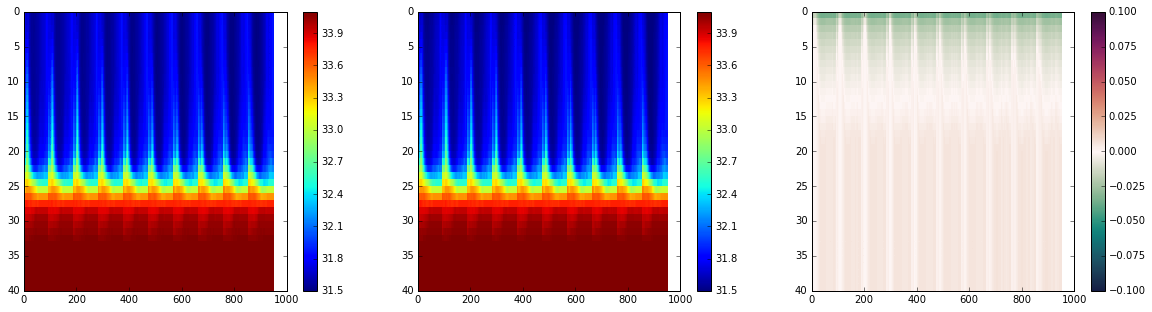

In [104]:
fig, ax = plt.subplots(1,3 ,figsize=(20,5))
mesh = ax[0].pcolormesh(salt_before[:,0], vmax=34.1, vmin = 31.5)
fig.colorbar(mesh, ax=ax[0])
mesh = ax[1].pcolormesh(salt_after[:,0], vmax=34.1, vmin = 31.5)
fig.colorbar(mesh, ax=ax[1])
mesh = ax[2].pcolormesh(salt_after[:, 0] - salt_before[:, 0], cmap=cm.curl, vmax=0.1, vmin=-0.1)
fig.colorbar(mesh, ax=ax[2])
for ax in [ax[0], ax[1], ax[2]]:
    ax.invert_yaxis()
print (np.max(salt_after - salt_before), np.min(salt_after - salt_before))

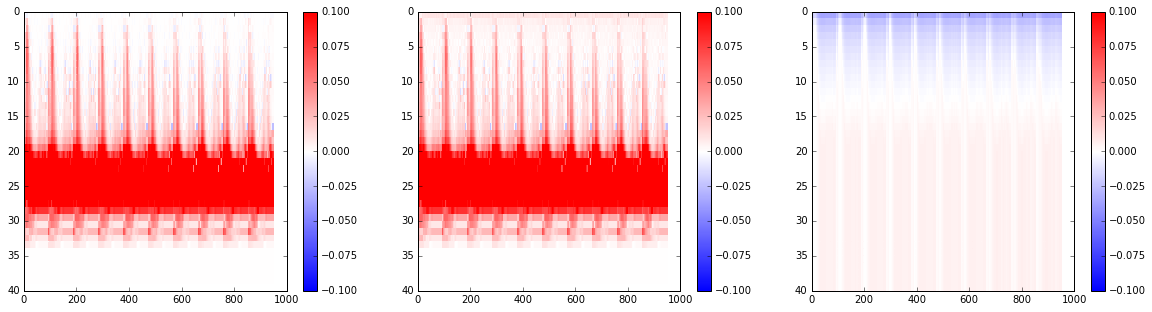

In [102]:
fig, ax = plt.subplots(1,3 ,figsize=(20,5))
mesh = ax[0].pcolormesh(salt_before[1:, 0] -salt_before[:-1, 0], cmap='bwr', vmax=0.1, vmin=-0.1)
fig.colorbar(mesh, ax=ax[0])
mesh = ax[1].pcolormesh(salt_after[1:, 0] - salt_after[:-1, 0], cmap='bwr', vmax=0.1, vmin=-0.1)
fig.colorbar(mesh, ax=ax[1])
mesh = ax[2].pcolormesh(salt_after[:, 0] - salt_before[:, 0], cmap='bwr', vmax=0.1, vmin=-0.1)
fig.colorbar(mesh, ax=ax[2])
for ax in [ax[0], ax[1], ax[2]]:
    ax.invert_yaxis()

In [51]:
temp_before = before.variables['votemper'][0]
temp_after = after.variables['votemper'][0]

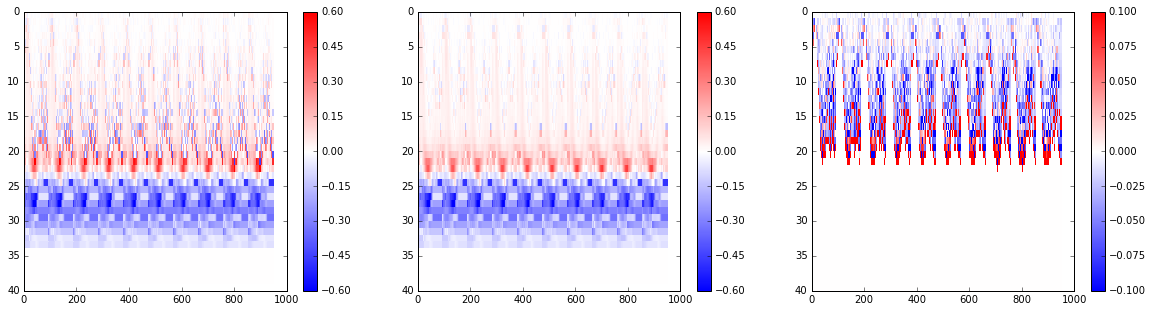

In [63]:
fig, ax = plt.subplots(1,3 ,figsize=(20,5))
mesh = ax[0].pcolormesh(temp_before[1:, 0] - temp_before[0:-1, 0], cmap='bwr', vmin=-0.6, vmax=0.6 )
fig.colorbar(mesh, ax=ax[0])
mesh = ax[1].pcolormesh(temp_after[1:, 0] -temp_after[0:-1, 0], cmap='bwr', vmin=-0.6, vmax=0.6)
fig.colorbar(mesh, ax=ax[1])
mesh = ax[2].pcolormesh(temp_after[:, 0] - temp_before[:, 0], cmap='bwr', vmax=0.1, vmin=-0.1)
fig.colorbar(mesh, ax=ax[2])
for ax in [ax[0], ax[1], ax[2]]:
    ax.invert_yaxis()